In [1]:
import core.utils.configuration

Config = core.utils.configuration.initialize_config()

with Config:
    # Config.Model.Name = 'pose_resnet50'
    # Config.Model.Param = dict(pretrained_path = r'D:\Portfolio\Golfer_Motion_Tracking\DL_approach\prototype\pose_resnet_50_384x288.pth.tar')
    Config.Model.Name = 'Unet'
    Config.Model.Param = dict(encoder_name='efficientnet-b4',decoder_attention_type='scse')
    
    Config.Training.Settings.TrailNumber = 1
    Config.Training.Settings.Epochs = 3
    Config.Training.Settings.AmpScaleTrain = True
    
    Config.Training.Settings.Random.RootSeed = 100
    Config.Training.Settings.Random.cuDNN.Deterministic = True
    Config.Training.Settings.Random.cuDNN.Benchmark = True
    Config.Training.Dataset.CocoPath = 'D:/Datasets/coco2017'
    Config.Training.Dataset.GolferPath = r'D:\Datasets\Golf\IdealsLab2\data'
    Config.Training.Dataset.Select.BaseCount = 100
    Config.Training.Dataset.Select.Golfer = 0
    Config.Training.Dataset.Select.CocoHuman = 8
    Config.Training.Dataset.Select.CocoDummy = 0
    Config.Training.Dataset.NumWorkers = 0
    Config.Training.Dataset.PinMemory = False
    Config.Training.Dataset.PrefetchFactor = 2
    Config.Training.Dataset.Train.BatchSize = 16
    Config.Training.Dataset.Val.BatchSize = 16

    Config.Training.HybridLoss = {
        'multi_human_heatmap_param':        dict(shcedule=0),
        'leading_role_heatmap_param':       dict(shcedule=1),
        'golfclub_heatmap_param':           dict(shcedule=0),
        'leading_role_keypoints_param':     dict(shcedule=0,bbox_size=10),
        'leading_role_keypoints_cf_param':  dict(shcedule=0,delta=0.5,gamma=0.5,label_smoothing=0.05),
        'golfclub_keypoints_param':         dict(shcedule=0,bbox_size=10),
        'golfclub_keypoints_cf_param':      dict(shcedule=0,delta=0.8,gamma=0.7,label_smoothing=0.05),
        'leading_role_bbox_param':          dict(shcedule=0),
        'leading_role_bbox_cf_param':       dict(shcedule=0,delta=0.5,gamma=0.5,label_smoothing=0.05)
    }
    
    Config.Training.Optimizer.Name = 'Adam'
    Config.Training.Optimizer.Param = {'lr':0.001}
    Config.Training.LearningRateSchedule.Name = 'LinearWarmupExpReduce'
    Config.Training.LearningRateSchedule.Param = {'warmup_epochs':2}
    
    Config.Record.Frequence = 8
    Config.Record.RootPath = 'test_save_folder'
    Config.Record.SaveModelWeights = True
    Config.Record.VisualizeRatio = 1
    Config.Record.DetectThreshold = 0.5
    Config.Record.Note = ''

In [ ]:
%run train.py

In [2]:
import core.utils

model = core.utils.get_model(Config)

In [3]:
model = model.cpu()

In [4]:
import torch

In [5]:
output = model(torch.ones((1,3,288,512),dtype=torch.float32))

In [6]:
output['multi_people_heatmap'].shapes

torch.Size([1, 17, 144, 256])

In [2]:
dataloaders = core.utils.get_dataloaders(Config)

loading annotations into memory...
Done (t=9.98s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [4]:
train_batch_data = next(iter(dataloaders['train'](0)))
val_batch_data = next(iter(dataloaders['val'](0)))

EPOCH: 0:   0%|          | 0/39 [00:04<?, ?it/s]


In [4]:
import torch
model = core.utils.get_model(Config)
model.load_state_dict(torch.load(r'D:\Portfolio\Golfer_Motion_Tracking\DL_approach\implementation\loggings\logging14\model_weights\000.pt'))
model = model.cpu()
model.eval()

Model(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
       

In [21]:
import matplotlib.pyplot as plt

In [8]:
with torch.no_grad():
    x = model(train_batch_data['image'])
    
# x = model.inference(x)

core.utils.record_inference(Config,10,train_batch_data['image'],x)

In [10]:
torch.nn.functional.mse_loss(x['leading_role_heatmap'],train_batch_data['leading_role_heatmap']['heatmap'])

tensor(3.3453)

In [5]:
train_batch_data['multi_people_heatmap'] = train_batch_data['multi_people_heatmap']['heatmap']
train_batch_data['leading_role_heatmap'] = train_batch_data['leading_role_heatmap']['heatmap']
train_batch_data['golfclub_heatmap'] = train_batch_data['golfclub_heatmap']['heatmap']

val_batch_data['multi_people_heatmap'] = val_batch_data['multi_people_heatmap']['heatmap']
val_batch_data['leading_role_heatmap'] = val_batch_data['leading_role_heatmap']['heatmap']
val_batch_data['golfclub_heatmap'] = val_batch_data['golfclub_heatmap']['heatmap']

In [8]:
train_batch_data['image']

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [9]:
val_batch_data['image']

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -1.9980, -2.0665, -1.9980],
          [-2.1179, -2.1179, -2.1179,  ..., -2.0665, -2.0665, -1.9638],
          [-2.1179, -2.1179, -2.1179,  ..., -2.0665, -2.0665, -1.9638],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -1.9132, -1.9307, -1.8957],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9832, -1.9132, -1.8606],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9832, -1.9132, -1.8431],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.7347, -1.7522, -1.6824],
          [-1.8044, -1.8044, -

In [6]:
core.utils.record_inference(Config,1,train_batch_data['image'],train_batch_data)
core.utils.record_inference(Config,1,val_batch_data['image'],val_batch_data)

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import core.dataset.training as training

reader = training.DataReader('train',f'D:/Datasets/coco2017',r'D:\Datasets\Golf\IdealsLab2\data')
reader = reader(2,0.25)

data_aug_processor = training.DataAugProcessor()
data_non_aug_processor = training.DataNonAugProcessor()

def vis_data(i,reader,dataprocessor):
    data = dataprocessor(reader[i])

    image = data['image']
    image = image.numpy().transpose([1,2,0])
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image,0,1)

    image_shape = image.shape[:2][::-1]

    plt.title('multi_people_heatmap flag:{}'.format(bool(data['multi_people_heatmap']['flag'])))
    plt.imshow(image)
    plt.imshow(cv2.resize(data['multi_people_heatmap']['heatmap'].max(axis=0),image_shape),alpha=0.5)
    plt.show()

    plt.title('leading_role_heatmap flag:{}'.format(bool(data['leading_role_heatmap']['flag'])))
    plt.imshow(image)
    plt.imshow(cv2.resize(data['leading_role_heatmap']['heatmap'].max(axis=0),image_shape),alpha=0.5)
    plt.show()

    plt.title('golfclub_heatmap flag:{}'.format(bool(data['golfclub_heatmap']['flag'])))
    plt.imshow(image)
    plt.imshow(cv2.resize(data['golfclub_heatmap']['heatmap'].max(axis=0),image_shape),alpha=0.5)
    plt.show()

    for i in range(17):
        if data['leading_role_keypoints']['cf'][i] == 1:
            xy = (data['leading_role_keypoints']['xy'][i] * np.array(image_shape)).astype(int)
            cv2.circle(image,xy,5,(1,0,0),2)
        else:
            assert (data['leading_role_keypoints']['xy'][i] == 0).all()

    for i in range(2):
        if data['golfclub_keypoints']['cf'][i] == 1:
            xy = (data['golfclub_keypoints']['xy'][i] * np.array(image_shape)).astype(int)
            cv2.circle(image,xy,5,(0,0,1),2)
        else:
            assert (data['golfclub_keypoints']['xy'][i] == 0).all()
            
    if data['leading_role_bbox']['cf'] == 1:
        xywh = (data['leading_role_bbox']['xywh'] * np.array([image_shape,image_shape]).flatten()).astype(int)
        cv2.rectangle(image,xywh[:2],xywh[:2]+xywh[2:],(1,0,0),2)
    else:
        assert (data['leading_role_bbox']['xywh'] == 0).all()
        
    plt.title('\n'.join([
        'leading_role_keypoints flag:{}'.format(bool(data['leading_role_keypoints']['flag'])),
        'leading_role_bbox flag:{}'.format(bool(data['leading_role_bbox']['flag'])),
        'golfclub_keypoints flag:{} {}'.format(bool(data['golfclub_keypoints']['flag']),data['golfclub_keypoints']['cf'].astype(bool))
        ]))
    plt.imshow(image)
    plt.show()

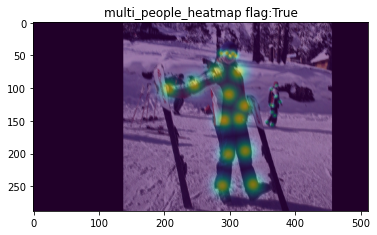

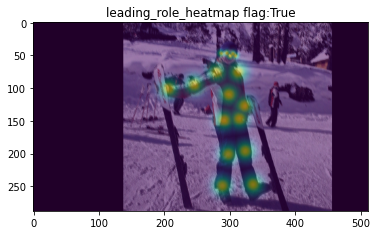

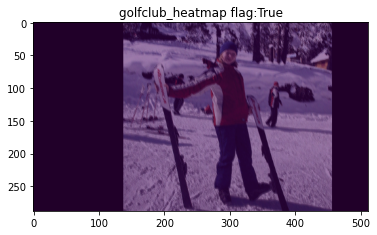

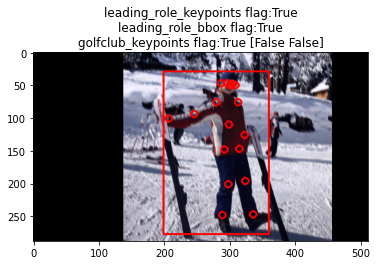

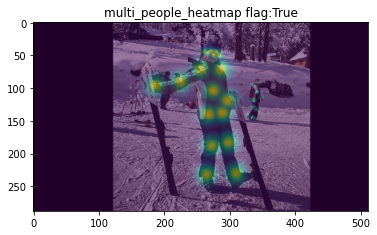

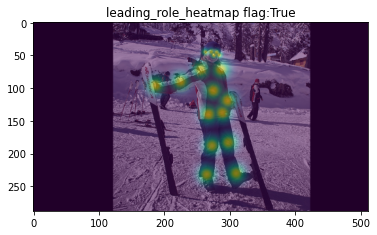

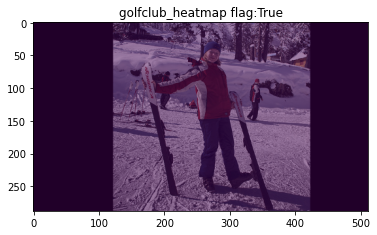

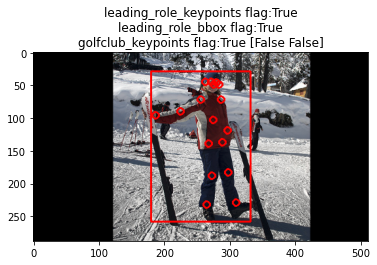

In [41]:
i = 1100
vis_data(i,reader,data_aug_processor)
vis_data(i,reader,data_non_aug_processor)

In [9]:
import torch

In [13]:
x = torch.tensor([[1,1],[0,0]],dtype=torch.float32)
y = torch.tensor([[0,1],[2,3]],dtype=torch.float32)

torch.nn.functional.mse_loss(x,y,reduction='none')

tensor([[1., 0.],
        [4., 9.]])